In [1]:
!pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 33.8 MB/s eta 0:00:00


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# pennylane
import pennylane as qml
from functools import partial

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

# MNIST Dataset
from tensorflow.keras.datasets import mnist

# Dataset Preparation and other Info

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


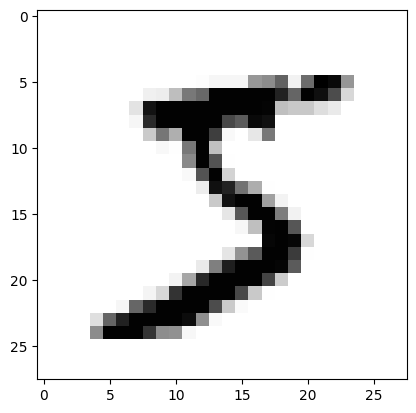

In [8]:
# Load MNIST dataset using TensorFlow
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

# extract one image data
plt.imshow(train_images[0, :, :], cmap='Greys')

In [9]:
# get ranges for normalization
print('max:', np.max(train_images[0, :, :]), 'min:', np.min(train_images[0, :, :]))

max: 255 min: 0


As we would see in the encoding section, the best we can do to store classical information in qubits limits to $2^{n}$ classical features into n qubits

To store 784 pixel data into amplitude, we need atleast a 10 qubit state to store the image data. This when put into a circuit to compare 2 images, the qubit requirements may go to 25-30 qubits. Simulating this circuit will go beyond the compute limits.  
  
  
So we reduce the image size to 16x16 = 256 pixel values. This can be put into a 8 qubit state, reducing the qubit sizes as much as possible.

(60000, 28, 28, 1)
(60000, 16, 16, 1)


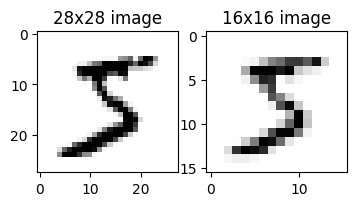

In [10]:
# visual comparison between 28x28 and 16x16 images

train_images = train_images.reshape(-1, 28, 28, 1).astype(np.float32) / 255.0  # Reshape into 4d array and normalize
print(train_images.shape)

# resize the images to 16x16
X_train = tf.image.resize(train_images, [16,16])
print(X_train.shape)

plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.imshow(train_images[0, :, :], cmap='Greys')
plt.title('28x28 image')

plt.subplot(1, 2, 2)
plt.imshow(X_train[0, :, :], cmap='Greys')
plt.title('16x16 image')

plt.show()

We normalize the data arrays from ranges [0, 255] to [0, 1], And resize the images to 16x16, and also prepare a dataset to batch two random images and provide it every time we iterate through it. (custom dataset is made in tensorflow)

In [11]:
def prepare_dataset(batch_size):
    # Load MNIST dataset
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') / 255.0  # Normalize pixel values
    print(x_train.shape)
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_train = tf.image.resize(x_train, [16,16])
    x_train = tf.squeeze(x_train)
    x_train = tf.reshape(x_train, [60000, -1])
    print(x_train.shape)
    # Convert labels to one-hot encoding
    # y_train = tf.one_hot(y_train, depth=10)

    # Create TensorFlow dataset from the MNIST data
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

    return dataset


# obtain a train dataset for later use
batch_size = 2 # atleast 2 has to be chosen to get 2 images to be compared and contrasted
train_dataset = prepare_dataset(batch_size)

(60000, 28, 28)
(60000, 256)


# Function Definitions

## 1. Image to State-Vector Function

We see that images are of size 16x16 ie., 256 pixels with each pixel having a float value. So to store their info, we require a state where we can encode atleast 256 values as amplitudes/phases.  

Available encoding methods are:  
1. Amplitude encoding - $2^{n}$ features into n qubits
2. Phase angle encoding - Encodes Max of n features into n qubits
3. Basis Encoding - Encodes n binary features into a basis state of n qubits.  

There are other encodings which are more complicated, but dont provide the high num_features to qubit ratio that amplitude encoding provides, So we go forward with amplitude encoding.

/usr/local/lib/python3.10/dist-packages/pennylane/workflow/qnode.py:475: UserWarning: Received gradient_kwarg wires, which is not included in the list of standard qnode gradient kwargs.
  warnings.warn(


(<Figure size 400x900 with 1 Axes>, <Axes: >)

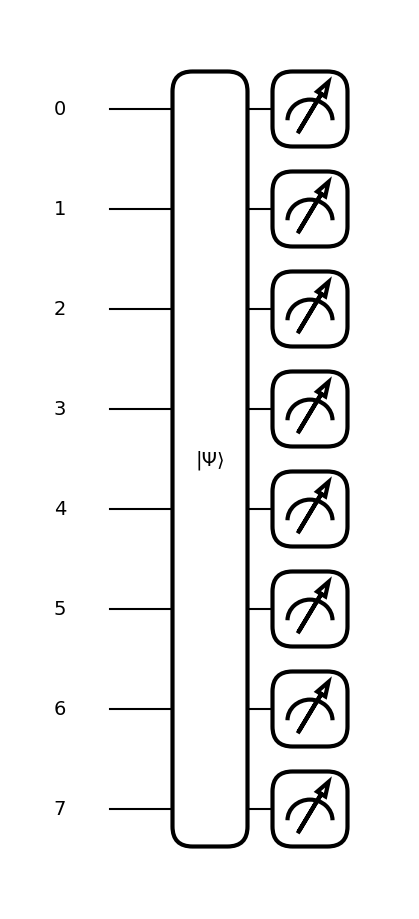

In [12]:
# image to state - Quantum Circuit / Pennylane function

num_qubits = 8

@qml.qnode(qml.device('default.qubit'), wires=8)
def imageToState(image_array, weights):
    # image_array is (16, 16) shaped 2d numpy array
    # weights are (256,) shaped numpy 1d array
    flattened = tf.reshape(image_array, [-1])
    features = flattened * weights
    qml.AmplitudeEmbedding(features=features, wires=range(num_qubits), normalize=True)

    return qml.state()


qml.draw_mpl(imageToState)(np.random.rand(16, 16), np.random.rand(256))

## 2. Circuit function for Swap Test and Fidelity

In [13]:
@qml.qnode(qml.device('default.qubit'))
def swapTestCircuit(state1, state2):
    # state1, state2 are 8 qubit states initialized from image arrays
    # function returns the measurement from the topmost qubit (wire0) where the swap test results are stored

    # initialize states
    qml.QubitStateVector(state1, wires=range(1, 9))
    qml.QubitStateVector(state2, wires=range(9, 17))

    qml.Barrier(wires=range(16))

    # swap test
    qml.Hadamard(0)
    for i in range(1, 9):
        qml.CSWAP(wires = [0, i, 8+i])
    qml.Hadamard(0)

    return qml.probs(wires=0)

def getFidelity(state1, state2):
    probs = swapTestCircuit(state1, state2)
    return probs[0]

(<Figure size 1500x1800 with 1 Axes>, <Axes: >)

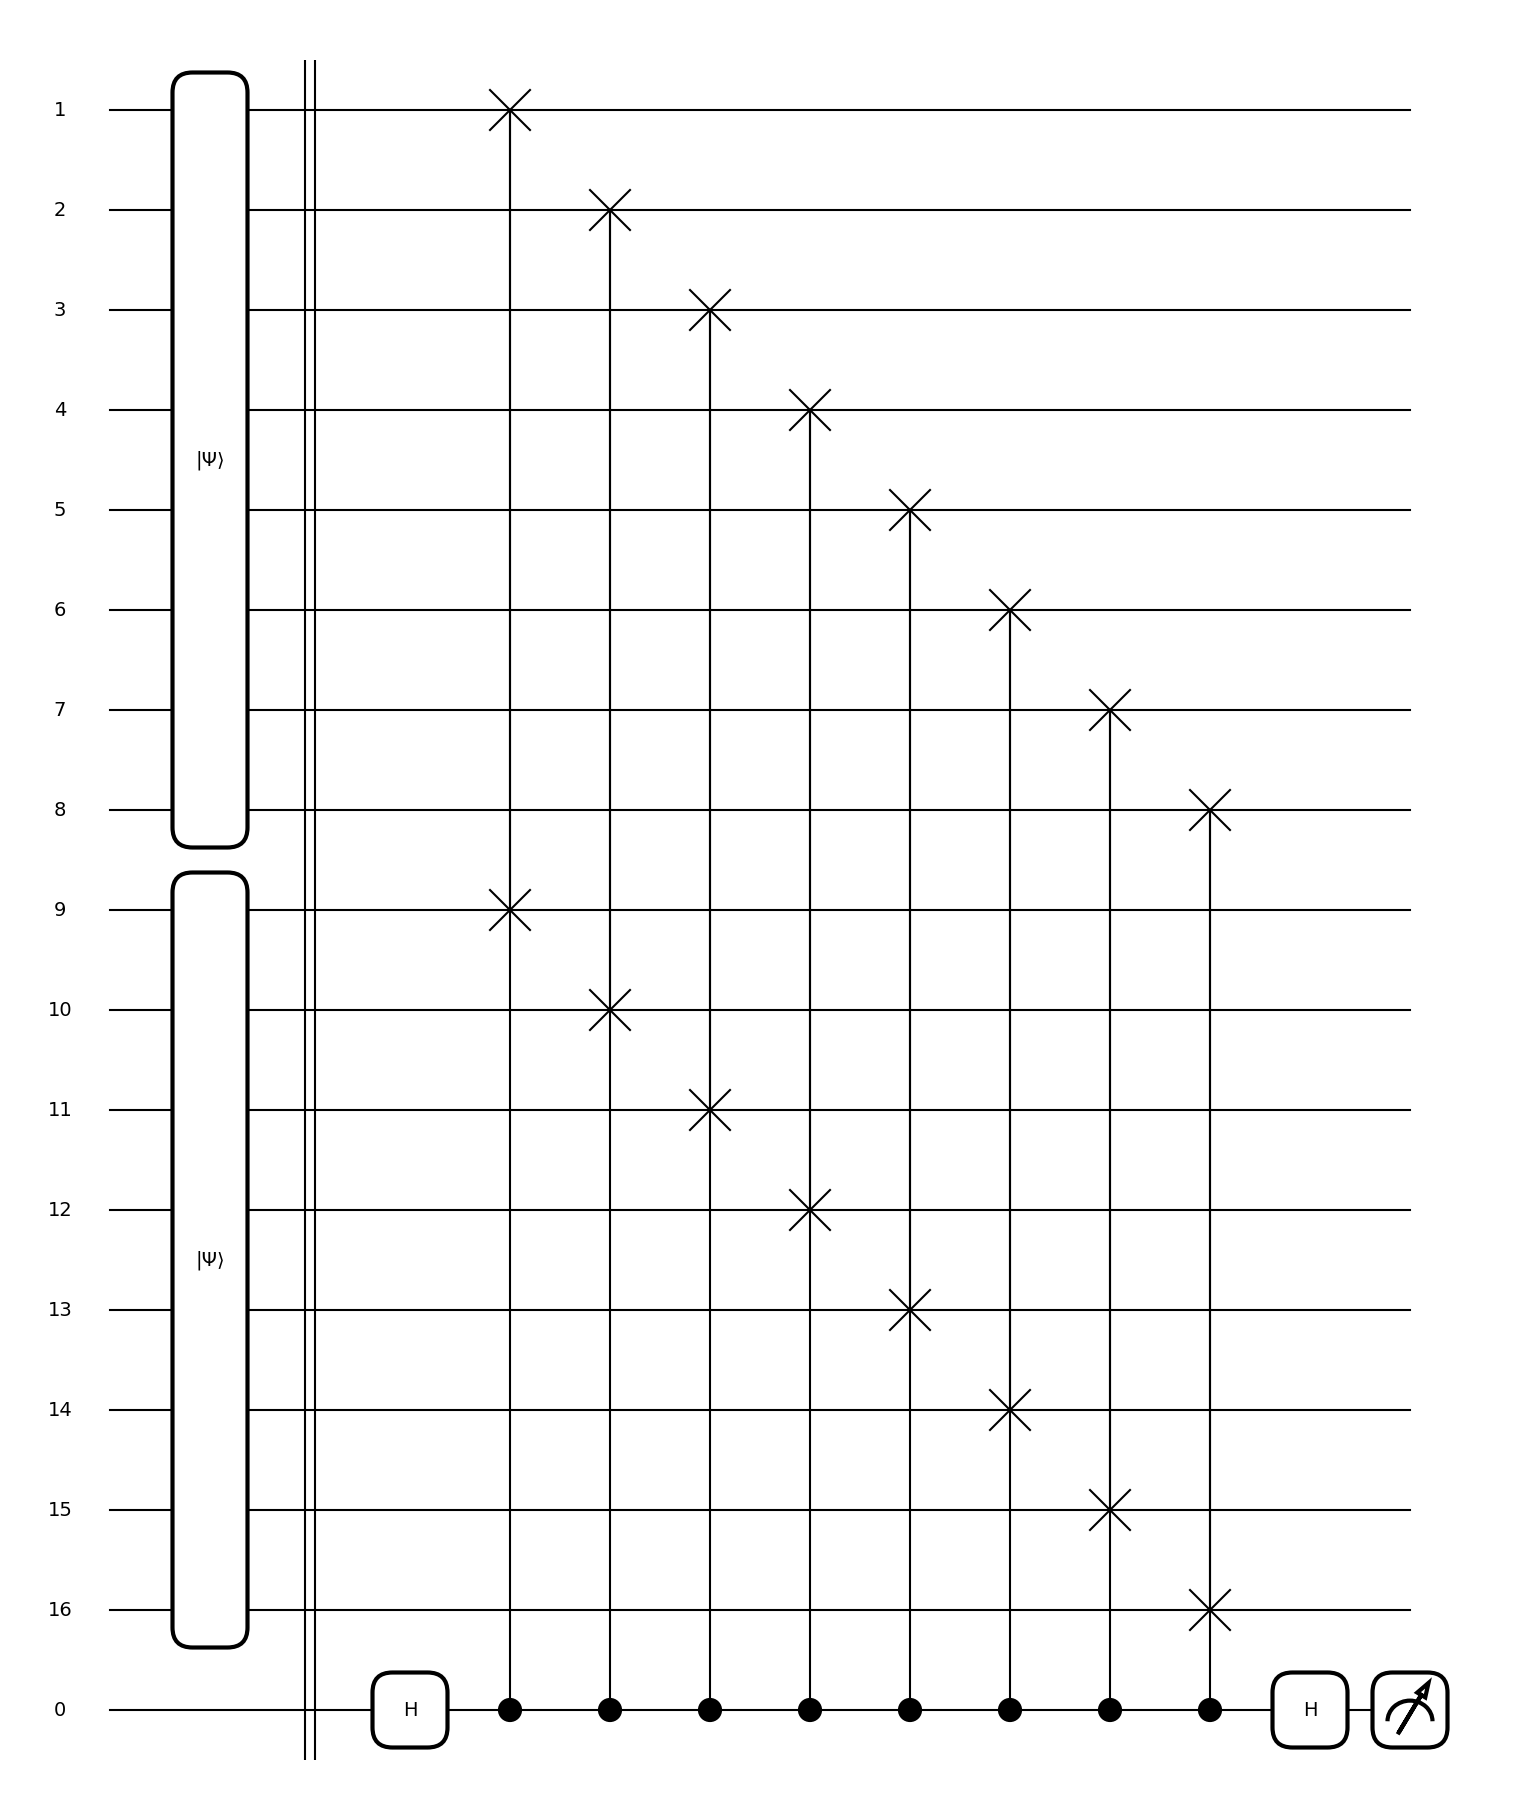

In [14]:
sv = imageToState(X_train[0, :, :, 0], np.random.rand(256))
qml.draw_mpl(swapTestCircuit)(sv, sv)

## 3. Combining them into single circuit

This makes the circuit to be easily embedded into the neural network

In [15]:
dev = qml.device("default.qubit")

# batch_params function is used to enable batched training of the model on mnist data
@partial(qml.batch_params, all_operations=True)
@qml.qnode(dev)
def swapTest(inputs, weights):
    image1 = inputs[:, 0:256]
    image2 = inputs[:, 256:512]

    # image to state and initialize
    features1 = image1 * weights
    qml.AmplitudeEmbedding(features=features1, wires=range(1, 9), normalize=True)
    features2 = image2 * weights
    qml.AmplitudeEmbedding(features=features2, wires=range(9, 17), normalize=True)

    # state1, state2 are 8 qubit states initialized from image arrays
    # function returns the measurement from the topmost qubit (wire0) where the swap test results are stored

    qml.Barrier(wires=range(17))

    # swap test
    qml.Hadamard(0)
    for i in range(1, 9):
        qml.CSWAP(wires = [0, i, 8+i])
    qml.Hadamard(0)

    return qml.probs(wires=0)

# uncomment and run to see the circuit
# qml.draw_mpl(swapTest)(np.random.rand(256*2), np.random.rand(256))

## 4. Hybrid Quantum-Classical NN model definition

using Keras Layer functionality of pennylane. Same can be done from pytorch as well. This task I will be doing this with tensorflow as I already explored dataloading and training Graph neural networks with pytorch (task-2)

In [16]:
# define model

# define quantum layer
weight_shapes = {"weights": 256}
output_dimen = 1 # since we get measurements of only one qubit
qlayer = qml.qnn.KerasLayer(swapTest, weight_shapes, output_dim=output_dimen)

# define classical layer to obtain fidelity at the end
class MaxOfTwoLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaxOfTwoLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Return the first output of all batches
        return inputs[:, 0]

get_fidelity_layer = MaxOfTwoLayer()


# string layers together
model = tf.keras.models.Sequential([qlayer, get_fidelity_layer])

# other hyper-parameters
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(opt, loss=loss_fn, metrics=["accuracy"])

This model consumes a lot of ram, as it has to simulate and train 17 qubit quantum network. Running on colab will not go past this stage, so try running this cell to verify if the model is working for a forward pass

In [17]:
# run this to verify, batched outputs out of quantum circuits

model(np.random.rand(32, 512))

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.7471916 , 0.77812773, 0.797869  , 0.7657964 , 0.81011903,
       0.7801069 , 0.7720183 , 0.7733801 , 0.74419475, 0.7894096 ,
       0.76696897, 0.76363134, 0.7868311 , 0.75211626, 0.7458878 ,
       0.7674922 , 0.79894775, 0.76400054, 0.8009435 , 0.7927398 ,
       0.79217494, 0.79748845, 0.76757455, 0.8003708 , 0.75577444,
       0.78264344, 0.77935374, 0.81031466, 0.8117033 , 0.77034324,
       0.75336236, 0.7830683 ], dtype=float32)>

## 5. Training Phase

You can either use the customized training loop, or ```model.fit()``` to train the model. I was able to run it for 2 epochs max using the custom training loop, but the training process crashed before that using the fit method due to excessive ram usage (in both laptop and colab).

In [ ]:
# customized training loop

epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    for step, (images, labels) in enumerate(train_dataset.take(1)):

        # start merging 2 images
        # Randomly select two indices
        indices = tf.random.shuffle(tf.range(batch_size))
        first_indices = indices[:batch_size // 2]
        second_indices = indices[batch_size // 2:]

        # Randomly shuffle the images and labels within the batch
        first_images = tf.gather(images, first_indices)
        first_labels = tf.gather(labels, first_indices)
        second_images = tf.gather(images, second_indices)
        second_labels = tf.gather(labels, second_indices)

        # Stack the images and labels into pairs
        image_pairs = tf.stack([first_images, second_images], axis=1)
        image_pairs = tf.reshape(image_pairs, (-1, 512))
        # label_pairs = tf.stack([first_labels, second_labels], axis=1)
        fidelity = (first_labels == second_labels)
        fidelity = tf.cast(fidelity, dtype=tf.int32)
        # end of merging 2 images

        with tf.GradientTape() as tape:
            # fit here
            y = model(image_pairs, training=True)

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(fidelity, y)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        opt.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 1 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))

        # use these print statements to check for the batched data dimensions
        # print("Image Pairs Shape:", image_pairs.shape)
        # print("fidelities:", fidelity.shape)


Start of epoch 0


In [ ]:
# this can also be used to train the model

# model.fit(np.random.rand(2, 512), np.random.rand(2), batch_size=2)

## 6. Model Evaluation

Although, evaluation does not make a lot of sense for representation learning, this result (with dummy values) is included to show that the model indeed works and performs quantum-classical forward passes

In [6]:
model.evaluate(np.random.rand(2, 512), np.random.rand(2))

1/1 [==============================] - 71s 71s/step - loss: 0.2683 - accuracy: 0.0000e+00


[0.2683209180831909, 0.0]

## 7. Extract and Save Weights after model is trained

In [ ]:
# save weights after the training process
model.save_weights("mnist_quantum_rep_weights.h5")